In [0]:
!python --version

Python 3.6.9


In [0]:
# !nvidia-smi

In [0]:
# Using GDrive storage as file-system for experimentation
import os
from google.colab import drive
try:
    drive.mount('/content/gdrive')
    os.chdir('gdrive/My Drive/Glaucoma')
except:
    pass

# Removing Permission if you want to unmount
# https://myaccount.google.com/permissions

os.getcwd()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Glaucoma'

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import os, shutil, datetime

import numpy as np, pandas as pd

from skimage.io import imread, imshow
from skimage.feature import hog
from skimage.transform import resize
from skimage.color import rgb2gray

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [0]:
dataset = 'Database-1'
true_path, false_path = 'Glaucoma', 'Healthy'

# orientations, pixels_per_cell, cells_per_block = 8, 64 , 1
orientations, pixels_per_cell, cells_per_block = 8, 8 , 1

In [0]:
MAX_H, MAX_W = 0, 0
for path in  true_path, false_path:
    ls = sorted(((img,imread(os.path.join('.',dataset,path,img)).shape) for img in os.listdir(os.path.join('.',dataset,path))),key=lambda x:x[1][0]*x[1][1], reverse=True)
    print( 'Total Shapes in {0} is {1:d}'.format(path,len(set(x[1] for x in ls))) )
    print(*set(x[1] for x in ls),sep='\n')
    MAX_H, MAX_W = max(MAX_H,max(x[1][0] for x in ls)), max(MAX_W,max(x[1][1] for x in ls))
# MAX_H, MAX_W = 32,32
MAX_H, MAX_W = int(pixels_per_cell*np.ceil(MAX_H/pixels_per_cell)), int(pixels_per_cell*np.ceil(MAX_W/pixels_per_cell))
print('Maximum Chosen Height is {0:d} pixels and width is {1:d} pixels'.format(MAX_H, MAX_W))

Total Shapes in Glaucoma is 1
(400, 600, 3)
Total Shapes in Healthy is 28
(733, 644, 3)
(785, 667, 3)
(748, 620, 3)
(709, 653, 3)
(998, 630, 3)
(729, 657, 3)
(795, 643, 3)
(800, 624, 3)
(795, 715, 3)
(809, 643, 3)
(771, 620, 3)
(738, 577, 3)
(842, 644, 3)
(857, 615, 3)
(701, 638, 3)
(899, 530, 3)
(866, 690, 3)
(1013, 705, 3)
(889, 667, 3)
(861, 667, 3)
(837, 743, 3)
(908, 691, 3)
(733, 615, 3)
(686, 624, 3)
(852, 672, 3)
(748, 667, 3)
(852, 653, 3)
(677, 586, 3)
Maximum Chosen Height is 1016 pixels and width is 744 pixels


In [0]:
def show_path(path,M,N):
    fig, ax = plt.subplots(M, N, figsize=(4*M, 5*N), sharex=True, sharey=True)
    fig.suptitle(path, size=36)
    for ix,img_name in enumerate(os.listdir(os.path.join('.',dataset,path))[:M*N]):
        img_mat = imread(os.path.join('.',dataset,path,img_name))
        img_mat = resize(img_mat,(MAX_H, MAX_W))
        ax[ix//M,ix%M].imshow(img_mat, cmap=plt.cm.gray) 
        ax[ix//M,ix%M].set_title(img_name, size=20)

def show_data(M=3, N=3):
    for path in (true_path,false_path):
        show_path(path,M,N)

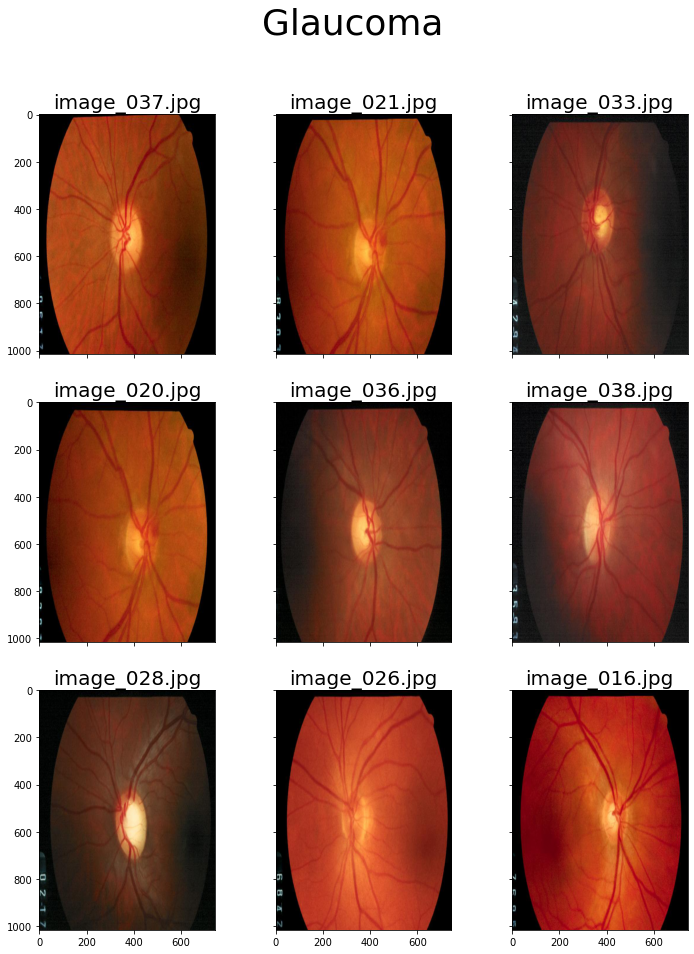

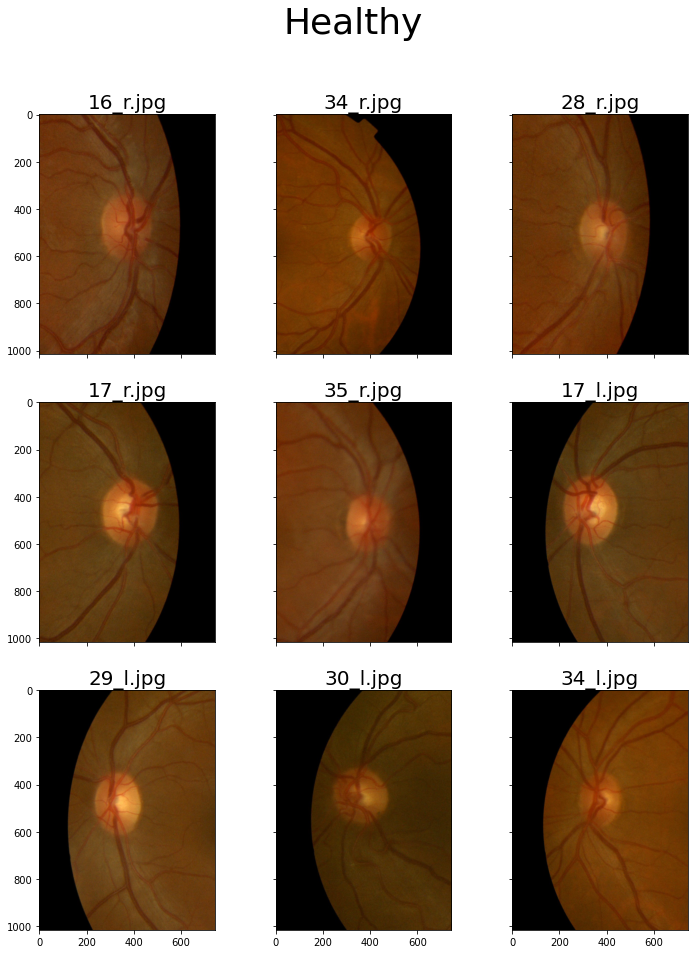

In [0]:
show_data(M=3, N=3)

In [0]:
def hog_of_path(path, orientations=10, pixels_per_cell=16, cells_per_block=2):
    res = []
    for img_name in os.listdir(os.path.join('.',dataset,path)):
        img_mat = imread(os.path.join('.',dataset,path,img_name))
        img_mat = resize(img_mat,(MAX_H, MAX_W))
        hog_vec = hog(img_mat, orientations=orientations, pixels_per_cell=(pixels_per_cell,pixels_per_cell), cells_per_block=(cells_per_block,cells_per_block))
        res.append( hog_vec )
    return np.array(res)

def get_data(dataset):
    x,y = [], []
    for path, label in zip((true_path,false_path),(1,0)):
        hog_ls = hog_of_path(path, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
        x.extend(hog_ls)
        y.extend([label]*len(hog_ls))
    return np.array(x), np.array(y)

In [0]:
%%time
x,y = get_data(dataset)

CPU times: user 41.5 s, sys: 6.64 s, total: 48.1 s
Wall time: 40.6 s


In [0]:
x.shape, y.shape, y.sum(), x.min(), x.max()

((64, 94488), (64,), 36, 0.0, 0.9999999987499999)

In [0]:
from sklearn.model_selection import StratifiedKFold

from sklearn.naive_bayes           import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.linear_model          import LogisticRegression
from sklearn.svm                   import SVC
from sklearn.ensemble              import RandomForestClassifier
from sklearn.neural_network        import MLPClassifier

from sklearn.metrics import accuracy_score

In [0]:
skf = StratifiedKFold(n_splits=5)

In [0]:
%%time
nb = GaussianNB()
for trn, tst in skf.split(x,y):
    _ = nb.fit(x[trn],y[trn])
    print( nb.score(x[tst],y[tst]), accuracy_score(nb.predict(x[tst]),y[tst]) )

1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
CPU times: user 600 ms, sys: 14.1 ms, total: 614 ms
Wall time: 615 ms


In [0]:
%%time
lda = LinearDiscriminantAnalysis()
for trn, tst in skf.split(x,y):
    _ = lda.fit(x[trn],y[trn])
    print( lda.score(x[tst],y[tst]), accuracy_score(lda.predict(x[tst]),y[tst]) )

1.0 1.0
0.9230769230769231 0.9230769230769231
1.0 1.0
1.0 1.0
1.0 1.0
CPU times: user 9.25 s, sys: 1.62 s, total: 10.9 s
Wall time: 6.48 s


In [0]:
%%time
knn = KNeighborsClassifier(n_neighbors=32)
for trn, tst in skf.split(x,y):
    _ = knn.fit(x[trn],y[trn])
    print( knn.score(x[tst],y[tst]), accuracy_score(knn.predict(x[tst]),y[tst]) )

0.6153846153846154 0.6153846153846154
0.5384615384615384 0.5384615384615384
0.5384615384615384 0.5384615384615384
0.5384615384615384 0.5384615384615384
0.5833333333333334 0.5833333333333334
CPU times: user 394 ms, sys: 89 ms, total: 483 ms
Wall time: 380 ms


In [0]:
%%time
knn = KNeighborsClassifier(n_neighbors=16)
for trn, tst in skf.split(x,y):
    _ = knn.fit(x[trn],y[trn])
    print( knn.score(x[tst],y[tst]), accuracy_score(knn.predict(x[tst]),y[tst]) )

1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
CPU times: user 1.48 s, sys: 2.4 ms, total: 1.48 s
Wall time: 1.48 s


In [0]:
%%time
lg = LogisticRegression()
for trn, tst in skf.split(x,y):
    _ = lg.fit(x[trn],y[trn])
    print( lg.score(x[tst],y[tst]), accuracy_score(lg.predict(x[tst]),y[tst]) )

1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
CPU times: user 7.08 s, sys: 2.5 s, total: 9.58 s
Wall time: 4.9 s


In [0]:
lg.predict_proba(x[tst])

array([[1.14799769e-03, 9.98852002e-01],
       [1.66680070e-03, 9.98333199e-01],
       [3.05649296e-04, 9.99694351e-01],
       [7.10630437e-04, 9.99289370e-01],
       [3.24602636e-04, 9.99675397e-01],
       [2.49632929e-04, 9.99750367e-01],
       [3.04225572e-04, 9.99695774e-01],
       [9.99574534e-01, 4.25466480e-04],
       [9.99477040e-01, 5.22960499e-04],
       [9.97775165e-01, 2.22483479e-03],
       [9.99574254e-01, 4.25746348e-04],
       [9.99185057e-01, 8.14943195e-04]])

In [0]:
y[tst]

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [0]:
%%time
svc = SVC(kernel='poly',degree=1)
for trn, tst in skf.split(x,y):
    _ = svc.fit(x[trn],2*y[trn]-1)
    print( svc.score(x[tst],2*y[tst]-1), accuracy_score(svc.predict(x[tst]),2*y[tst]-1) )

1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
CPU times: user 2.93 s, sys: 72.9 ms, total: 3.01 s
Wall time: 2.94 s


In [0]:
%%time
svc = SVC(kernel='rbf')
for trn, tst in skf.split(x,y):
    _ = svc.fit(x[trn],2*y[trn]-1)
    print( svc.score(x[tst],2*y[tst]-1), accuracy_score(svc.predict(x[tst]),2*y[tst]-1) )

1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
CPU times: user 3.36 s, sys: 3.16 ms, total: 3.36 s
Wall time: 3.36 s


In [0]:
%%time
rf = RandomForestClassifier(n_estimators=5, max_features=40, max_depth=10)
for trn, tst in skf.split(x,y):
    _ = rf.fit(x[trn],y[trn])
    print( rf.score(x[tst],y[tst]), accuracy_score(rf.predict(x[tst]),y[tst]) )

1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
CPU times: user 199 ms, sys: 945 µs, total: 200 ms
Wall time: 198 ms


In [0]:
sorted(rf.feature_importances_,reverse=True)[:10]

[0.1697263544536272,
 0.15862068965517243,
 0.14519104084321477,
 0.1422222222222222,
 0.12436363636363637,
 0.07563636363636364,
 0.057777777777777775,
 0.05480895915678522,
 0.041379310344827586,
 0.015232323232323227]

In [0]:
%%time
rf = RandomForestClassifier(n_estimators=100, max_features=40, max_depth=10)
for trn, tst in skf.split(x,y):
    _ = rf.fit(x[trn],y[trn])
    print( rf.score(x[tst],y[tst]), accuracy_score(rf.predict(x[tst]),y[tst]) )

1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
CPU times: user 1.05 s, sys: 11.5 ms, total: 1.06 s
Wall time: 1.06 s


In [0]:
sorted(rf.feature_importances_,reverse=True)[:10]

[0.019257142857142858,
 0.01,
 0.01,
 0.01,
 0.01,
 0.00925925925925926,
 0.009257142857142858,
 0.009257142857142858,
 0.009257142857142858,
 0.00925287356321839]

In [0]:
%%time
mlp = MLPClassifier()
for trn, tst in skf.split(x,y):
    _ = mlp.fit(x[trn],y[trn])
    print( mlp.score(x[tst],y[tst]), accuracy_score(mlp.predict(x[tst]),y[tst]) )

0.6923076923076923 0.6923076923076923
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
CPU times: user 44.4 s, sys: 13.7 s, total: 58.1 s
Wall time: 34.3 s


In [0]:
confusion_mat_dict = {
    'KNN':((15+11),(15+11+0+4)),
    'SVM':((15+12),(15+12+0+3)),
    'LDA':((15+12),(14+12+1+3)),
    'GNB':((15+13),(15+13+0+0)),
    'ANN':((34+28),(34+28+0+2)),
}

accuracy_dict = {
    'KNN':86.0,
    'SVM':90.0,
    'LDA':86.0,
    'GNB':96.0,
    'ANN':96.9,
}

In [0]:
for key in accuracy_dict:
    samples = confusion_mat_dict[key][1]
    given_acc = accuracy_dict[key]
    calc_acc = confusion_mat_dict[key][0]*100/samples
    print('Algo {0} Total samples{1:4d} Tabular Accuracy {2:5.3f} Accuracy from Confusion matrix {3:5.3f}'.format(key,samples,given_acc, calc_acc))

Algo KNN Total samples  30 Tabular Accuracy 86.000 Accuracy from Confusion matrix 86.667
Algo SVM Total samples  30 Tabular Accuracy 90.000 Accuracy from Confusion matrix 90.000
Algo LDA Total samples  30 Tabular Accuracy 86.000 Accuracy from Confusion matrix 90.000
Algo GNB Total samples  28 Tabular Accuracy 96.000 Accuracy from Confusion matrix 100.000
Algo ANN Total samples  64 Tabular Accuracy 96.900 Accuracy from Confusion matrix 96.875


In [0]:
path = false_path
dir_ls = os.listdir(os.path.join('.',dataset,path))
np.random.shuffle(dir_ls)
img_name =  dir_ls[0]
img_mat = imread(os.path.join('.',dataset,path,img_name))
img_mat.max()

255

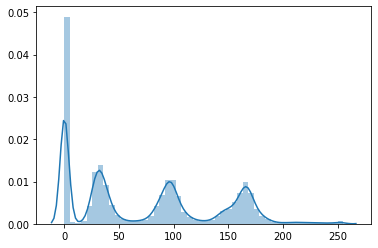

In [0]:
dst_obj = sns.distplot(np.ravel(img_mat))

(0, 255, dtype('uint8'))

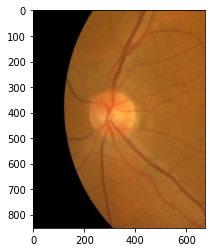

In [0]:
plt.imshow(img_mat)
img_mat.min(), img_mat.max(), img_mat.dtype

In [0]:
def normalize(img_mat, color=True):
    if not color:
        img_mat = rgb2gray(img_mat)
    img_mat = img_mat.astype('float32')
    if color:
        min_val, max_val = img_mat.min(axis=(0,1)).reshape(-1,1,1), img_mat.max(axis=(0,1)).reshape(-1,1,1)
        return np.clip(np.round(255*(img_mat.T-min_val)/(max_val-min_val)) , 0 , 255).T.astype('uint8')
    else:
        min_val, max_val = img_mat.min(), img_mat.max()
        return np.clip(np.round(255*(img_mat-min_val)/(max_val-min_val)) , 0 , 255).astype('uint8')

(0, 255)

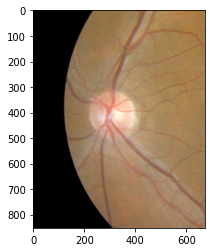

In [0]:
color_norm = True
if color_norm:
    norm_img_mat = normalize(img_mat,color=True)
    plt.imshow(norm_img_mat,vmin=0, vmax=255)
else:
    norm_img_mat = normalize(img_mat,color=False)
    plt.imshow(norm_img_mat,vmin=0, vmax=255,cmap='gray')
norm_img_mat.min(), norm_img_mat.max()

In [0]:
# color_norm = False
# if color_norm:
#     norm_img_mat = normalize(img_mat,color=True)
#     plt.imshow(norm_img_mat,vmin=0, vmax=255)
# else:
#     norm_img_mat = normalize(img_mat,color=False)
#     plt.imshow(norm_img_mat,vmin=0, vmax=255,cmap='gray')
# norm_img_mat.min(), norm_img_mat.max()

In [0]:
def change_fill(img_mat, removal_frac=0.2, replace_frac=None):
    if len(img_mat.shape)==3:
        arr = np.ravel(np.clip(np.round(255*rgb2gray(img_mat)),0,255).astype('uint8'))
        hist_obj = plt.hist(arr,bins=20)
    else:
        arr = np.ravel(img_mat)
        hist_obj = plt.hist(arr,bins=20)
    freq, buck = hist_obj[0], hist_obj[1]
    if buck[0] <= 255*removal_frac:
        if replace_frac is None:
            replace_frac = removal_frac
        if len(img_mat.shape)==3:
            arr = np.clip(np.round(255*rgb2gray(img_mat)),0,255).astype('uint8').T
            arr = np.array([arr,arr,arr]).T
            replace_arr = np.ones((img_mat.shape))
            for ix in range(3):
                replace_arr[:,:,ix] = np.quantile(np.ravel(img_mat[:,:,ix]),replace_frac)
            img_mat = np.where( arr<np.clip(np.round(255*removal_frac),0,255) , replace_arr , img_mat ).astype('uint8')
        else:
            replace_arr = np.quantile(np.ravel(img_mat),replace_frac)
            img_mat = np.where( img_mat<np.clip(np.round(255*removal_frac),0,255) , replace_arr , img_mat )
    plt.clf()
    return img_mat

In [0]:
# norm_img_mat.max(), norm_img_mat.dtype, rgb2gray(norm_img_mat.astype('float32')).max(), rgb2gray(norm_img_mat).max()

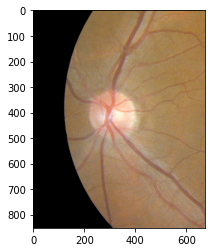

In [0]:
change_img_mat = change_fill(norm_img_mat,0.2)
plt.imshow(change_img_mat,cmap='gray',vmin=0, vmax=255)

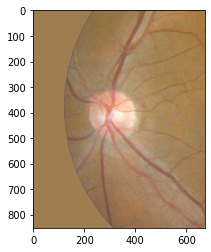

In [0]:
change_img_mat = change_fill(norm_img_mat,0.25,0.5)
plt.imshow(change_img_mat,cmap='gray',vmin=0, vmax=255)

In [0]:
import cv2 
def find_center(img_mat):
    gray_img_mat = np.clip(np.round(255*rgb2gray(img_mat.copy())),0,255).astype('uint8')
    radius = 2*max(img_mat.shape[0]//32,img_mat.shape[1]//32) + 1
    print(radius)
    gb_gray_img_mat = cv2.GaussianBlur(gray_img_mat, (radius,radius), 0)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(gb_gray_img_mat)
    dsply = img_mat.copy()
    cv2.circle(dsply, maxLoc, radius, (255, 0, 0), 2)
    plt.imshow(dsply)
    return maxLoc, gb_gray_img_mat

53


((408, 334), (852, 672))

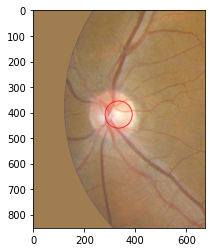

In [0]:
center_coord, gb_gray_img_mat = find_center(change_img_mat)
center_coord = center_coord[::-1]
center_coord, gb_gray_img_mat.shape

In [0]:
y_cen, x_cen = center_coord
x_slice, y_slice = gb_gray_img_mat[:,x_cen], gb_gray_img_mat[y_cen,:]
x_rng, y_rng = np.quantile(x_slice,1/np.e), np.quantile(y_slice,1/np.e)
x_cen, y_cen, x_slice.shape, y_slice.shape, x_rng, y_rng

(334, 408, (852,), (672,), 129.0, 133.0)

In [0]:
y_l, y_r = 0,0
x_bool = x_slice>=x_rng
while True:
    if (y_cen-(y_l+1))>=0 and x_bool[(y_cen-(y_l+1))]:
        y_l+=1
    else:
        break
while True:
    if (y_cen+(y_r+1))<x_bool.shape[0] and x_bool[(y_cen+(y_r+1))]:
        y_r+=1
    else:
        break
y_step = min(y_l, y_r)

x_l, x_r = 0,0
y_bool = y_slice>=y_rng
while True:
    if (x_cen-(x_l+1))>=0 and y_bool[(x_cen-(x_l+1))]:
        x_l+=1
    else:
        break
while True:
    if (x_cen+(x_r+1))<y_bool.shape[0] and y_bool[(x_cen+(x_r+1))]:
        x_r+=1
    else:
        break
x_step = min(x_l, x_r)

(x_cen, x_step),(y_cen, y_step), (y_l, y_r), (x_l, x_r)

((334, 129), (408, 153), (153, 273), (129, 297))

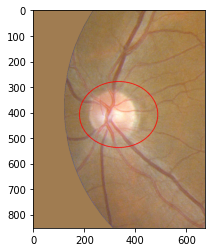

In [0]:
ellp_img = change_img_mat.copy()
cv2.ellipse(ellp_img, (x_cen, y_cen),(y_step, x_step),0,0,360,(255,0,0),2)
# cv.ellipse(img,(256,256),(100,50),0,0,180,255,-1)
plt.imshow(ellp_img)

In [0]:
ellp_img = change_img_mat.copy()
cv2.ellipse(ellp_img, (x_cen, y_cen),(y_step, x_step),0,0,360,(0,0,0),-1)
masked_img = np.where(ellp_img==0,change_img_mat,change_img_mat[0][0])

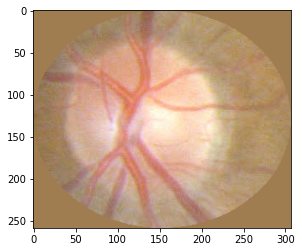

In [0]:
crop_img = masked_img[y_cen-x_step:y_cen+x_step+1,x_cen-y_step:x_cen+y_step+1]
plt.imshow(crop_img)

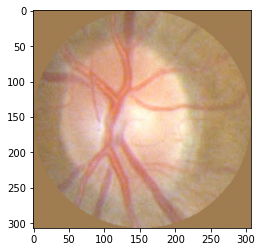

In [0]:
plt.imshow( resize(crop_img,(max(crop_img.shape),max(crop_img.shape))) )